In [2]:
import os
import sys
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
import random
from collections import defaultdict
from facenet_pytorch import InceptionResnetV1
import torch.nn as nn
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
import time
from sklearn.metrics import recall_score, precision_score
import itertools
import copy
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import arc_scores
import helper
import evaluate

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class FaceFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root # directory
        self.transform = transform
        self.samples = []   # (img_path, label)
        self.labels = []

        persons = sorted(os.listdir(root))
        for label, person in enumerate(persons):
            self.labels.append(label)
            folder = os.path.join(root, person)
            if not os.path.isdir(folder):
                continue
            imgs = glob.glob(os.path.join(folder, "*"))
            for img_path in imgs:
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    # allow to use [] to access the index
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
class PKSampler(Sampler):
    def __init__(self, dataset, P, K, samples_per_class_per_epoch=5):
        """
        dataset: FaceFolderDataset object
        P: số classes mỗi batch
        K: số samples mỗi class
        """
        self.P = P
        self.K = K
        self.samples_per_class = samples_per_class_per_epoch
        self.label2indices = defaultdict(list)

        # lấy labels từ samples
        for idx, (_, label) in enumerate(dataset.samples):
            self.label2indices[label].append(idx)

        self.labels = list(self.label2indices.keys())
        self.n_classes = len(self.labels)

        # Tính số batches
        self.batches_per_epoch = (self.n_classes * self.samples_per_class + P - 1) // P

        total_images = sum(len(indices) for indices in self.label2indices.values())

        print(f"\n{'='*60}")
        print(f"PKSampler Info:")
        print(f"{'='*60}")
        print(f"Total images: {total_images}")
        print(f"Total classes: {self.n_classes}")
        print(f"Avg images/class: {total_images/self.n_classes:.1f}")
        print(f"Samples per class per epoch: {self.samples_per_class}")
        print(f"Batches per epoch: {self.batches_per_epoch}")
        print(f"Total samples per epoch: {self.batches_per_epoch * P * K}")
        print(f"Coverage: {(self.batches_per_epoch * P * K) / total_images * 100:.1f}%")
        print(f"Expected time per epoch: ~{self.batches_per_epoch * 0.15:.1f}s (assuming 0.15s/batch)")
        print(f"{'='*60}\n")

    def __iter__(self):
        # Mỗi class lặp lại samples_per_class lần
        class_pool = []
        for _ in range(self.samples_per_class):
            shuffled = self.labels.copy()
            random.shuffle(shuffled)
            class_pool.extend(shuffled)

        random.shuffle(class_pool)

        for batch_idx in range(self.batches_per_epoch):
            start = batch_idx * self.P
            batch_labels = class_pool[start:start + self.P]

            if len(batch_labels) < self.P:
                break

            batch = []
            for label in batch_labels:
                indices = self.label2indices[label]

                if len(indices) >= self.K:
                    selected = random.sample(indices, k=self.K)
                else:
                    selected = random.choices(indices, k=self.K)

                batch.extend(selected)

            yield from batch

    def __len__(self):
        return self.batches_per_epoch * self.P * self.K

In [6]:
class BatchHardTripletLoss(nn.Module):
    def __init__(self, margin=0.2, mode='semi_hard'):
        super().__init__()
        self.margin = margin
        self.mode = mode

    def update_strategy(self, mode):
        self.mode = mode

    def forward(self, embs, labels):
        dist = torch.cdist(embs, embs)

        labels = labels.view(-1, 1)
        pos_mask = labels.eq(labels.t())
        neg_mask = ~pos_mask

        eye = torch.eye(len(labels), dtype=torch.bool, device=labels.device)
        pos_mask[eye] = False

        # Kiểm tra có positive không (mỗi sample cần ít nhất 1 positive)
        valid_samples = pos_mask.any(dim=1)

        if self.mode == "semi_hard":
            # Dùng CLOSEST positive (theo paper gốc FaceNet)
            pos_dist = dist.clone()
            pos_dist[~pos_mask] = 1e9
            closest_pos = pos_dist.min(dim=1)[0]  # MIN - positive gần nhất

            neg_dist = dist.clone()
            neg_dist[~neg_mask] = 1e9

            # Semi-hard negative: d(anchor, pos) < d(anchor, neg) < d(anchor, pos) + margin
            semi_mask = (neg_dist > closest_pos.unsqueeze(1)) & \
                        (neg_dist < (closest_pos + self.margin).unsqueeze(1))

            semi_neg = neg_dist.clone()
            semi_neg[~semi_mask] = 1e9
            semi_neg = semi_neg.min(dim=1)[0]

            # Fallback: nếu không tìm được semi-hard, dùng hardest negative
            hardest_neg = neg_dist.min(dim=1)[0]
            semi_neg = torch.where(semi_neg >= 1e6, hardest_neg, semi_neg)

            loss = torch.relu(closest_pos - semi_neg + self.margin)

            # Chỉ tính loss cho samples có positive
            if valid_samples.all():
                return loss.mean()
            else:
                return loss[valid_samples].mean() if valid_samples.any() else torch.tensor(0.0, device=embs.device)

        # Batch-hard mode: dùng hardest positive và hardest negative
        # Hardest positive: positive xa nhất
        pos_dist = dist.clone()
        pos_dist[~pos_mask] = -1e9
        hardest_pos = pos_dist.max(dim=1)[0]

        # Hardest negative: negative gần nhất
        neg_dist = dist.clone()
        neg_dist[~neg_mask] = 1e9
        hardest_neg = neg_dist.min(dim=1)[0]

        loss = torch.relu(hardest_pos - hardest_neg + self.margin)

        # Chỉ tính loss cho samples có positive
        if valid_samples.all():
            return loss.mean()
        else:
            return loss[valid_samples].mean() if valid_samples.any() else torch.tensor(0.0, device=embs.device)

In [9]:
test_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])



test_path = 'test'

P, K = 256, 4

test_dataset = FaceFolderDataset(test_path, transform=test_transform)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=512,
    num_workers=0,
    shuffle=False,
    pin_memory=True,
)

In [10]:
class CNN(nn.Module):
    def __init__(self, embedding_dim=4096):
        super().__init__()

        # Phần CNN trích feature map
        self.cnn = nn.Sequential(
            # 160 -> 151
            nn.Conv2d(3, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 151 -> 75

            # 75 -> 69
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 69 -> 34

            # 34 -> 31
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 31 -> 15

            # 15 -> 12
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True)
        )

        # Tính kích thước sau CNN để gán cho FC
        # Với input 160x160 -> output 256x12x12
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 12 * 12, embedding_dim),
            nn.PReLU(),  # tốt hơn Sigmoid với face embedding
            nn.Linear(embedding_dim, embedding_dim),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        # Chuẩn hóa L2 để tính khoảng cách trong không gian metric
        return F.normalize(x, p=2, dim=1)


In [15]:
BEST_MODEL_PATH = "cnn_m0.3_trip.pt" 

if os.path.exists(BEST_MODEL_PATH):
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)

    model = CNN(embedding_dim=512).to(device)
    criterion = BatchHardTripletLoss(margin=0.3, mode='semi_hard')

    model_to_load = model.module if hasattr(model, 'module') else model

    model_state_dict = checkpoint['model_state_dict']
    new_model_state_dict = {}
    for k, v in model_state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_model_state_dict[name] = v

    model_to_load.load_state_dict(new_model_state_dict)

    best_tar = checkpoint['best_tar_far']
    print(f"Đã tải thành công mô hình tốt nhất của bạn với TAR@FAR = {best_tar:.4f}")

else:
    print(f"Không tìm thấy file {BEST_MODEL_PATH}. Vui lòng kiểm tra lại đường dẫn.")

Đã tải thành công mô hình tốt nhất của bạn với TAR@FAR = 0.4541


In [17]:
model.eval()
test_loss = []
embs = []
labels = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        with autocast(dtype=torch.float16):
            outputs = model(inputs)
            outputs = F.normalize(outputs, p=2, dim=1)
            loss = criterion(outputs, targets)

        test_loss.append(loss.item())
        embs.append(outputs.cpu())
        labels.append(targets.cpu())

  0%|          | 0/185 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_37452\2908224860.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
100%|██████████| 185/185 [03:26<00:00,  1.11s/it]


In [18]:
test_loss = np.mean(test_loss)
eval_res = evaluate.evaluate(embs, labels, max_per_class=50, n_linspace=1000)

print(f"\n{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Eval Metrics:")
print(f"  - Accuracy: {eval_res['accuracy']:.4f}")
print(f"  - ROC AUC: {eval_res['roc_auc']:.4f}")
print(f"  - TAR@FAR1e-3: {eval_res['tar_far_3']:.4f}")
print(f"  - TAR@FAR1e-4: {eval_res['tar_far_4']:.4f}")
print(f"  - Threshold: {eval_res['threshold']:.4f}")
print(f"{'='*60}\n")


Test Loss: 0.0180
Eval Metrics:
  - Accuracy: 0.8998
  - ROC AUC: 0.9623
  - TAR@FAR1e-3: 0.4534
  - TAR@FAR1e-4: 0.2774
  - Threshold: 0.2662



In [19]:
from view import eval_pairs, sample_correct_pairs, sample_incorrect_pairs, show_pairs

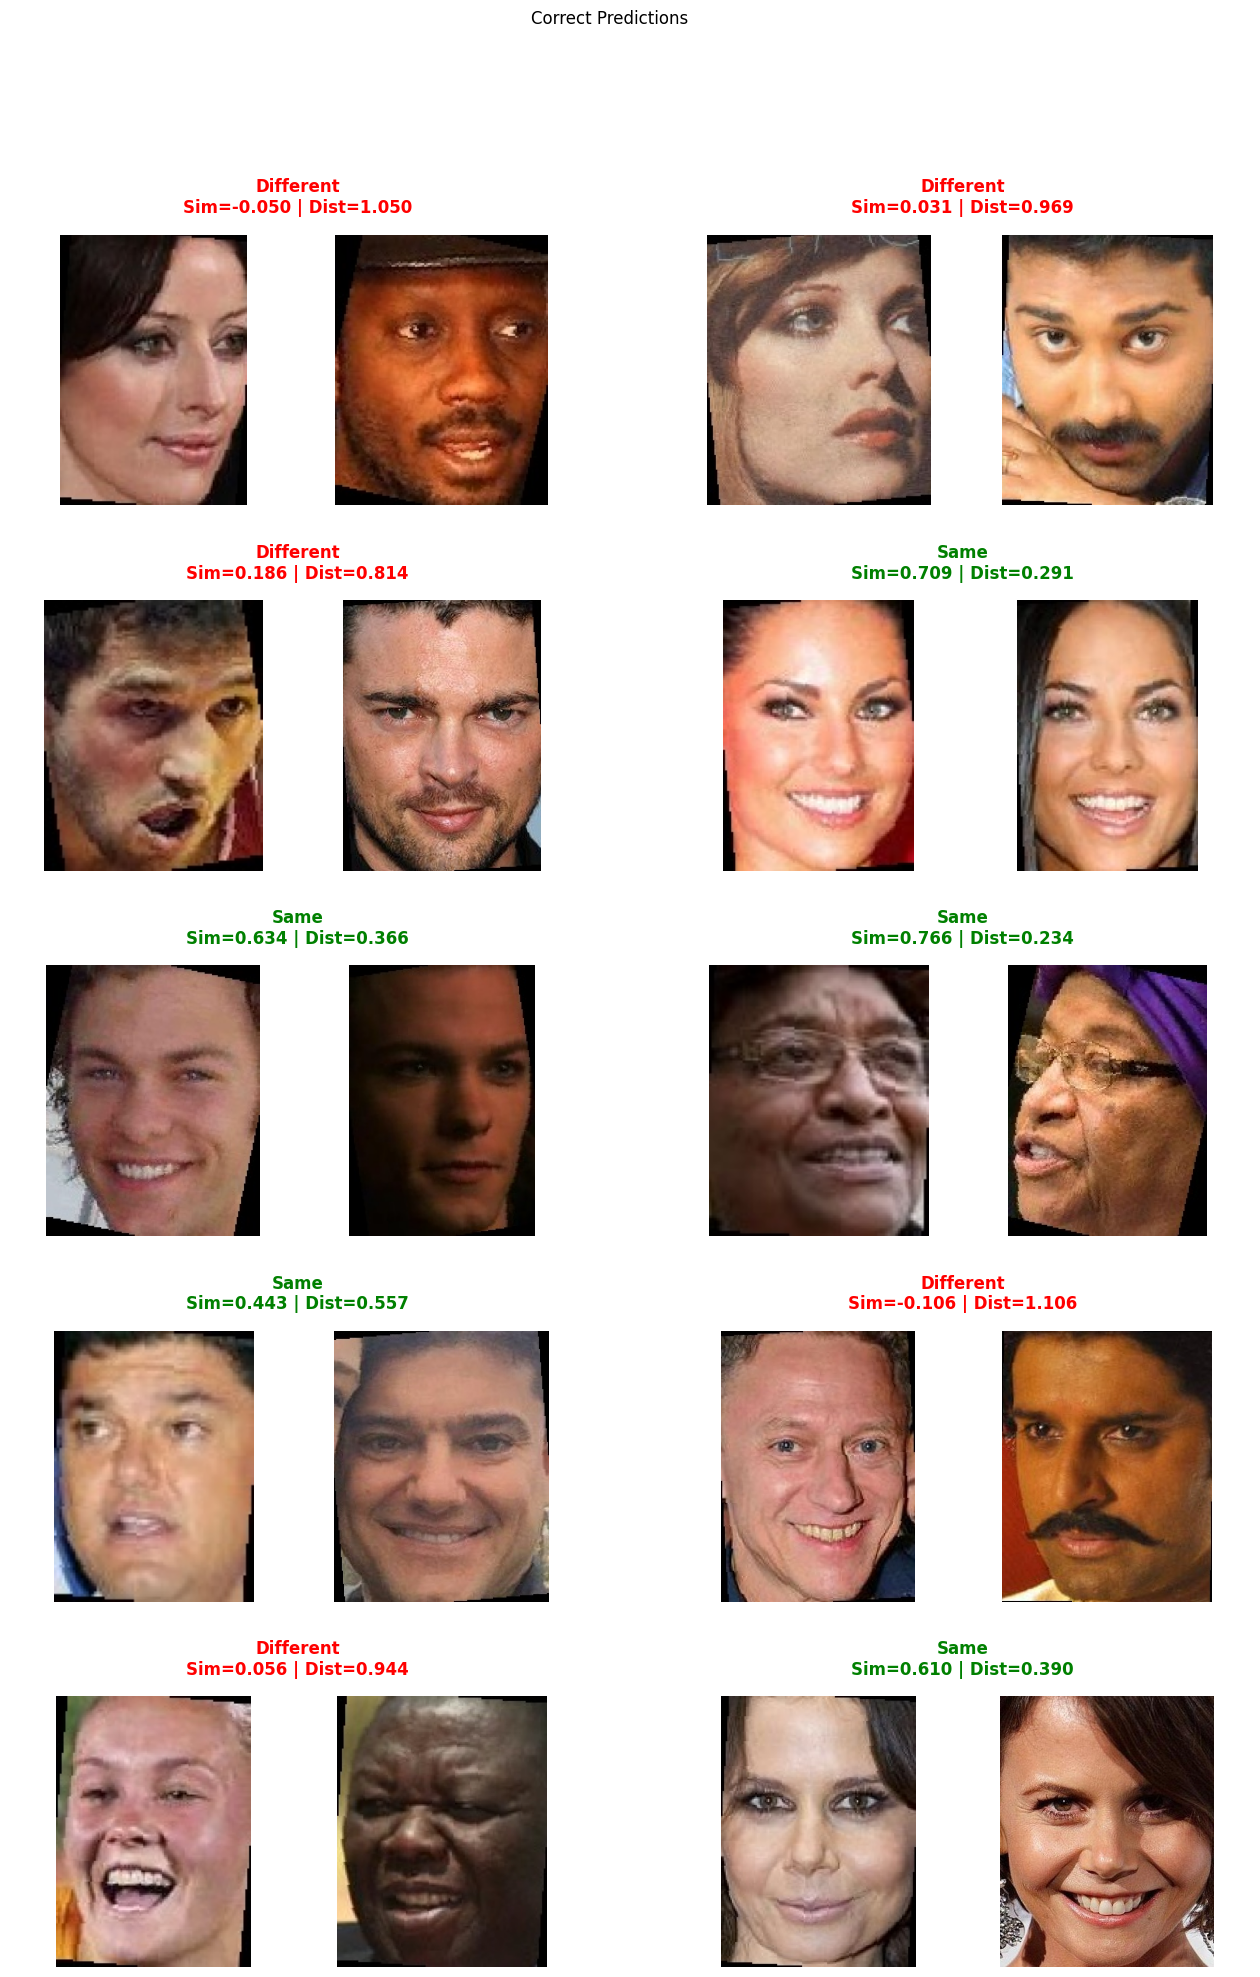

In [20]:
preds, pairs, sim_scores = eval_pairs(
    embs,
    labels,
    generate_pairs_fn=evaluate.generate_balanced_pairs,
    threshold=0.2882
)

paths = sample_correct_pairs(
    pairs, preds, sim_scores,
    test_dataset,
    n=10
)

show_pairs(paths, title="Correct Predictions")

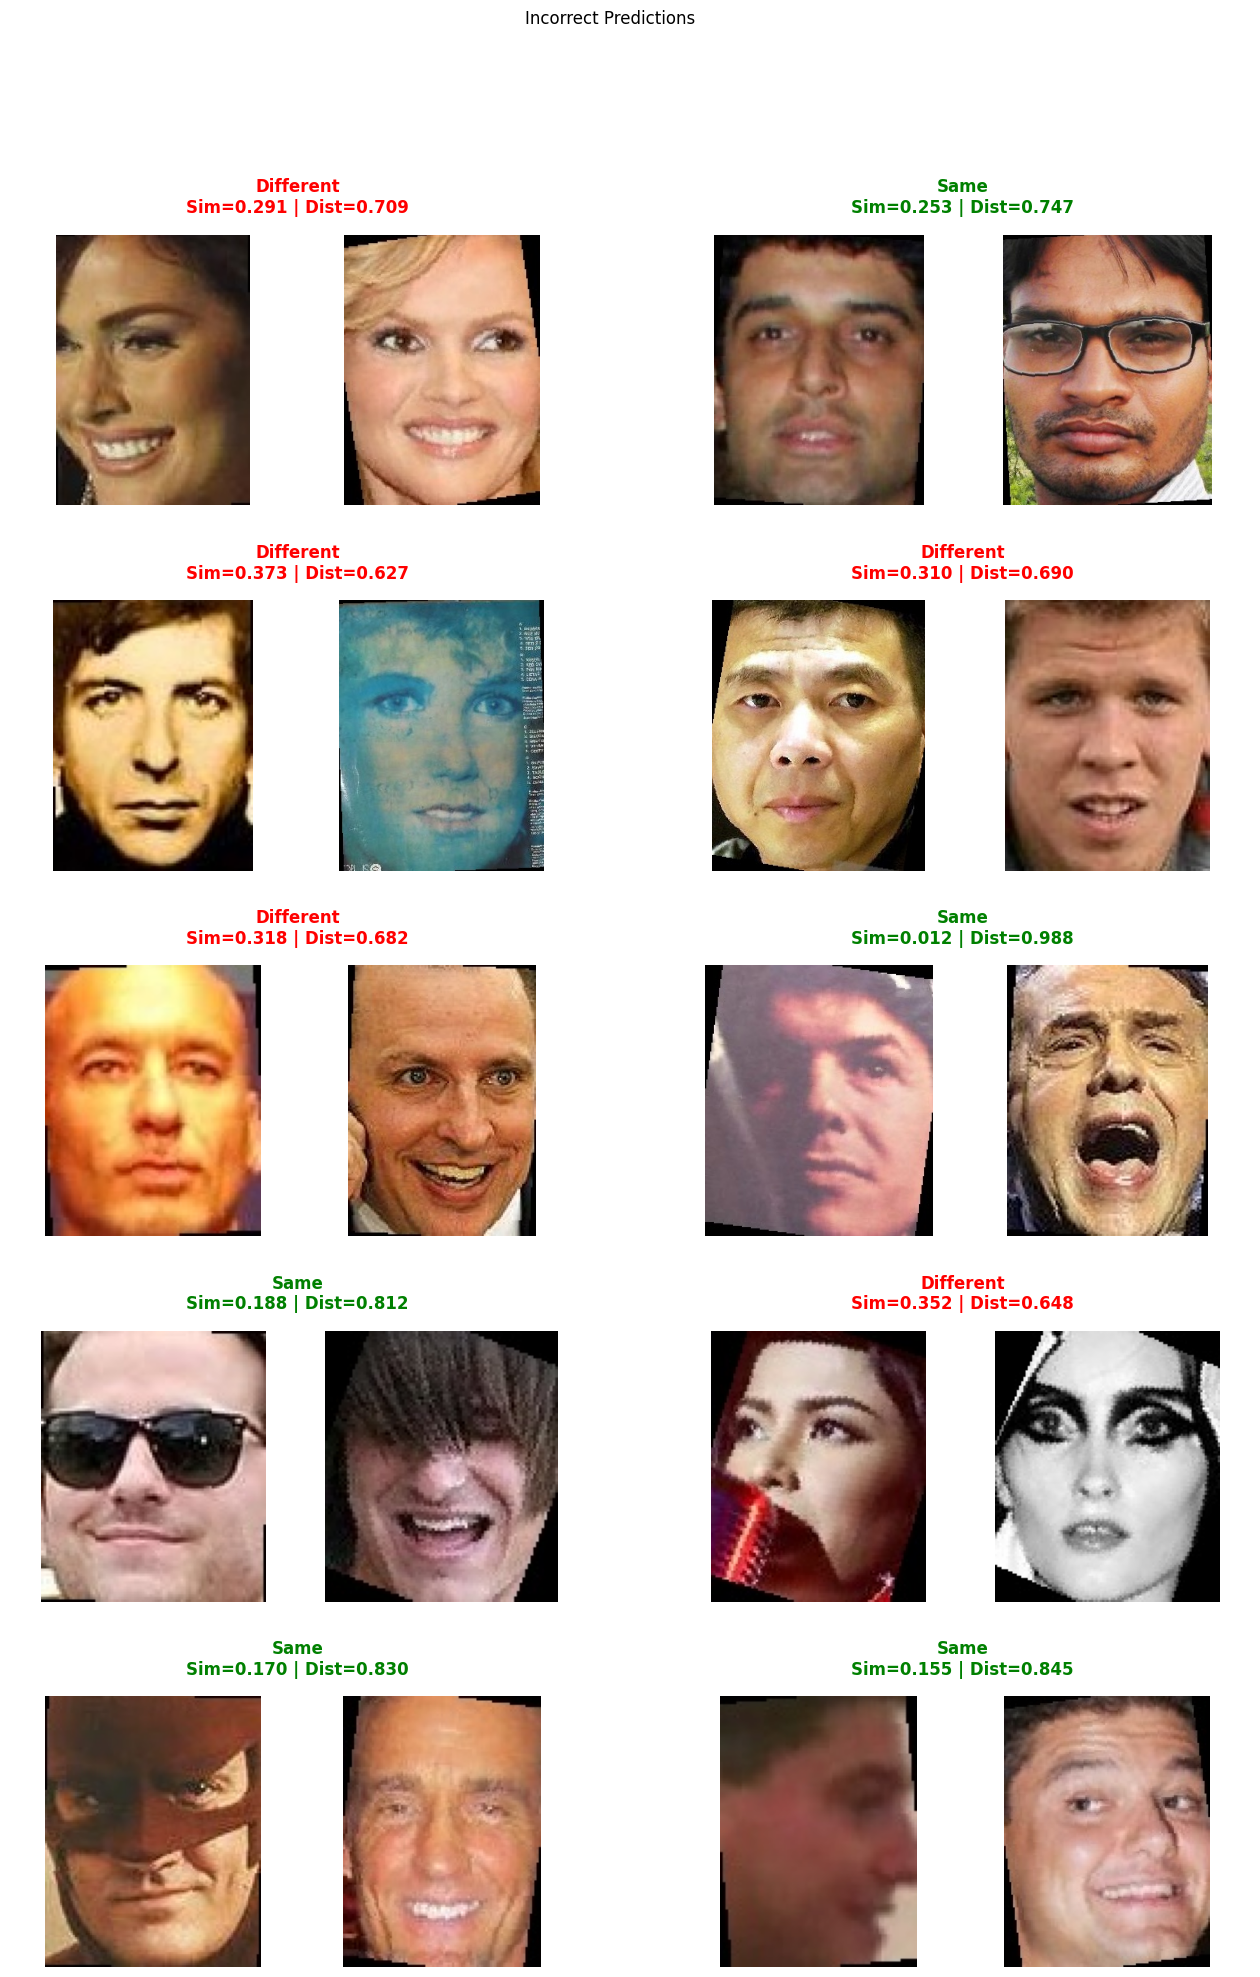

In [21]:
paths = sample_incorrect_pairs(
    pairs, preds, sim_scores,
    test_dataset,
    n=10
)

show_pairs(paths, title="Incorrect Predictions")